# Multiple layer models and Activation Functions

In this notebook we will explore network models with multiple layers of transformations. This will build upon the single-layer affine model we looked at in the previous notebook and use material covered in the second and third lectures.

You will need to use these models for the experiments you will be running in the first coursework so part of the aim of this lab will be to get you familiar with how to construct multiple layer models in our framework and how to train them.

## What is a layer?

Often when discussing (neural) network models, a network layer is taken to mean an input to output transformation of the form

\begin{equation}
    \boldsymbol{y} = \boldsymbol{f}(\mathbf{W} \boldsymbol{x} + \boldsymbol{b})
    \qquad
    \Leftrightarrow
    \qquad
    y_k = f\left(\sum_{d=1}^D \left( W_{kd} x_d \right) + b_k \right)
\end{equation}

where $\mathbf{W}$ and $\boldsymbol{b}$ parameterise an affine transformation as discussed in the previous notebook, and $f$ is a function applied elementwise to the result of the affine transformation (sometimes called the activation function). For example a common choice for $f$ is the logistic sigmoid function 
\begin{equation}
  f(u) = \frac{1}{1 + \exp(-u)}.
\end{equation}

In the second lecture slides you were shown how to train a model consisting of an affine transformation followed by the elementwise logistic sigmoid using gradient descent. This was referred to as a 'sigmoid single-layer network'.

In the previous notebook we also referred to single-layer models, where in that case the layer was an affine transformation, with you implementing the various necessary methods for the `AffineLayer` class before using an instance of that class within a `SingleLayerModel` on a regression problem. We could in that case consider the activation function $f$ to be the identity function $f(u) = u$. In the code for the labs we will however use a slightly different convention. Here we will consider the affine transformation and the subsequent activation function $f$ to be two separate transformation layers. 

This allows us to combine our already implemented `AffineLayer` class with any non-linear activation function applied to the outputs by simply implementing a layer object for the relevant non-linearity and then stacking the two layers together. An alternative would be to have our new layer objects inherit from `AffineLayer` and then call the relevant parent class methods in the child class; however, this would mean we need to duplicate a lot of the same boilerplate code in every new class.

To give a concrete example, in the `mlp.layers` module there is a definition for a `SigmoidLayer` equivalent to the following (documentation strings have been removed here for brevity)

```python
class SigmoidLayer(Layer):

    def fprop(self, inputs):
        return 1. / (1. + np.exp(-inputs))

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs * outputs * (1. - outputs)
```

As you can see this `SigmoidLayer` class has a very lightweight definition, defining just two key methods:

  * `fprop` which takes a batch of values at the input to the layer and forward propagates them to produce activations at the outputs (directly equivalently to the `fprop` method you implemented for then `AffineLayer` in the previous notebook),
  * `brop` which takes a batch of gradients with respect to the outputs of the layer and backward propagates them to calculate gradients with respect to the inputs of the layer (explained in more detail below).
  
This `SigmoidLayer` class only implements the logistic sigmoid non-linearity transformation and so does not have any parameters. Therefore unlike `AffineLayer` it is derived directly from the base `Layer` class rather than `LayerWithParameters` and does not need to implement `grads_wrt_params` or `params` methods. 

To create a model consisting of an affine transformation followed by applying an elementwise logistic sigmoid transformation we first create a list of the two layer objects (in the order they are applied from inputs to outputs) and then use this to instantiate a new `MultipleLayerModel` object:

```python
from mlp.layers import AffineLayer, SigmoidLayer
from mlp.models import MultipleLayerModel

layers = [AffineLayer(input_dim, output_dim), SigmoidLayer()]
model = MultipleLayerModel(layers)
```

Because of the modular way in which the layers are defined we can also stack an arbitrarily long sequence of layers together to produce deeper models. For instance the following would define a model consisting of three pairs of affine and logistic sigmoid transformations.

```python
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim), SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim), SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim), SigmoidLayer(),
])
```

## Back-propagation of gradients
  
To allow training models consisting of a stack of multiple layers, all layers need to implement a `bprop` method in addition to the `fprop` we encountered in the previous week. 

The `bprop` method takes gradients of an error function with respect to the *outputs* of a layer and uses these gradients to calculate gradients of the error function with respect to the *inputs* of a layer. As the inputs to a hidden layer in a multiple-layer model consist of the outputs of the previous layer, this means we can calculate the gradients of the error function with respect to the outputs of every layer in the model by iteratively propagating the gradients backwards through the layers of the model (i.e. from the last to first layer), hence the term 'back-propagation' or 'bprop' for short. A block diagram illustrating this is shown for a three layer model below.

<img src='res/fprop-bprop-block-diagram.png' />

For a layer with parameters, the gradients with respect to the layer outputs are required to calculate gradients with respect to the layer parameters. Therefore by combining backward propagation of gradients through the model with computing the gradients with respect to parameters in the relevant layers we can calculate gradients of the error function with respect to all of the parameters of a multiple-layer model in a very efficient manner (in fact the computational cost of computing gradients with respect to all of the parameters of the model using this method will only be a constant factor times the cost of calculating the model outputs in the forwards pass).

So far, we have abstractly talked about calculating gradients with respect to the inputs of a layer using gradients with respect to the layer outputs. More concretely we will be using the chain rule for derivatives to do this, similarly to how we used the chain rule in exercise 4 of the previous notebook to calculate gradients with respect to the parameters of an affine layer given gradients with respect to the outputs of the layer.

In particular if our layer has a batch of $B$ vector inputs each of dimension $D$, $\left\lbrace \boldsymbol{x}^{(b)} \right\rbrace_{b=1}^B$, and produces a batch of $B$ vector outputs each of dimension $K$, $\left\lbrace \boldsymbol{y}^{(b)}\right\rbrace_{b=1}^B$,  then we can calculate the gradient with respect to the $d^\textrm{th}$ dimension of the $b^{\textrm{th}}$ input using the gradients with respect to the $b^{\textrm{th}}$ output

\begin{equation}
    \frac{\partial \bar{E}}{\partial x^{(b)}_d} = 
    \sum_{k=1}^K \left( 
        \frac{\partial \bar{E}}{\partial y^{(b)}_k} \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} 
    \right).
\end{equation}

The `bprop` method takes an array of gradients with respect to the outputs $\frac{\partial y^{(b)}_k}{\partial x^{(b)}_d}$ and applies a sum-product operation with the partial derivatives of each output with respect to each input $\frac{\partial \bar{E}}{\partial y^{(b)}_k}$, producing gradients with respect to the inputs of the layer $\frac{\partial \bar{E}}{\partial x^{(b)}_d}$.

For the affine transformation used in the `AffineLayer` implemented in lab 2, i.e. a forward propagation corresponding to 

\begin{equation}
    y^{(b)}_k = \sum_{d=1}^D \left( W_{kd} x^{(b)}_d \right) + b_k
\end{equation}

then the corresponding partial derivatives of layer outputs with respect to inputs are

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = W_{kd}
\end{equation}

and so the backwards-propagation method for the `AffineLayer` takes the following form

\begin{equation}
    \frac{\partial \bar{E}}{\partial x^{(b)}_d} = 
    \sum_{k=1}^K \left( \frac{\partial \bar{E}}{\partial y^{(b)}_k} W_{kd} \right).
\end{equation}

This can be efficiently implemented in NumPy using the `dot` function

```python
class AffineLayer(LayerWithParameters):

    # ... [implementation of remaining methods from previous week] ...
    
    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs.dot(self.weights)
```

An important special case applies when the outputs of a layer are an elementwise function of the inputs such that $y^{(b)}_k$ only depends on $x^{(b)}_d$ when $d = k$. In this case the partial derivatives $\frac{\partial y^{(b)}_k}{\partial x^{(b)}_d}$ will be zero when $k \neq d$ and the above summation reduces to a single term,

\begin{equation}
    \frac{\partial \bar{E}}{\partial x^{(b)}_d} = 
    \frac{\partial \bar{E}}{\partial y^{(b)}_d} \frac{\partial y^{(b)}_d}{\partial x^{(b)}_d}
\end{equation}

i.e. to calculate the gradient with respect to the $b^{\textrm{th}}$ input vector we just perform an elementwise multiplication of the gradient with respect to the $b^{\textrm{th}}$ output vector with the vector of derivatives of the outputs with respect to the inputs. This case applies to the `SigmoidLayer` and to all other layers applying an elementwise function to their inputs.

For the logistic sigmoid layer we have that

\begin{equation}
    y^{(b)}_d = \frac{1}{1 + \exp(-x^{(b)}_d)}
    \qquad
    \Rightarrow
    \qquad
    \frac{\partial y^{(b)}_d}{\partial x^{(b)}_d} = 
    \frac{\exp(-x^{(b)}_d)}{\left[ 1 + \exp(-x^{(b)}_d) \right]^2} =
     y^{(b)}_d \left[ 1 -  y^{(b)}_d  \right]
\end{equation}

which you should now be able relate to the implementation of `SigmoidLayer.bprop` given earlier:

```python
class SigmoidLayer(Layer):

    def fprop(self, inputs):
        return 1. / (1. + np.exp(-inputs))

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs * outputs * (1. - outputs)
```

## Exercise 1: training a softmax model on MNIST

For this first exercise we will train a model consisting of an affine transformation plus softmax on a multiclass classification task: classifying the digit labels for handwritten digit images from the MNIST data set introduced in the first notebook.

First run the cell below to import the necessary modules and classes and to load the MNIST data provider objects. As it takes a little while to load the MNIST data from disk into memory it is worth loading the data providers just once in a separate cell like this rather than recreating the objects for every training run.

We are loading two data provider objects here - one corresponding to the training data set and a second to use as a *validation* data set. This is data we do not train the model on but measure the performance of the trained model on to assess its ability to *generalise* to unseen data. 

The concept of training, validation, and test data sets was introduced in lecture one, and the concept of generalisation is discussed in more detail in lecture five. As you will need to report both training and validation set performances in your experiments for the first coursework assignment we are providing code here to give an example of how to do this.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 10

To minimise replication of code and allow you to run experiments more quickly, a helper function is provided below which trains a model and plots the evolution of the error and classification accuracy of the model (on both training and validation sets) over training.

In [2]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, _ = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, fig_1, ax_1, fig_2, ax_2

Running the cell below will create a model consisting of an affine layer followed by a softmax transformation and train it on the MNIST data set by minimising the multi-class cross entropy error function using a basic gradient descent learning rule. By using the helper function defined above, at the end of training curves of the evolution of the error function and also classification accuracy of the model over the training epochs will be plotted.

You should try running the code for various settings of the training hyperparameters defined at the beginning of the cell to get a feel for how these affect how training proceeds. You may wish to create multiple copies of the cell below to allow you to keep track of and compare the results across different hyperparameter settings.

Epoch 5: 4.6s to complete
    error(train)=3.22e-01, acc(train)=9.11e-01, error(valid)=3.00e-01, acc(valid)=9.16e-01
Epoch 10: 4.0s to complete
    error(train)=2.95e-01, acc(train)=9.18e-01, error(valid)=2.81e-01, acc(valid)=9.21e-01
Epoch 15: 4.6s to complete
    error(train)=2.85e-01, acc(train)=9.21e-01, error(valid)=2.74e-01, acc(valid)=9.23e-01
Epoch 20: 4.1s to complete
    error(train)=2.78e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.25e-01
Epoch 25: 3.3s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.68e-01, acc(valid)=9.25e-01
Epoch 30: 3.6s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.64e-01, acc(valid)=9.27e-01
Epoch 35: 3.7s to complete
    error(train)=2.64e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.28e-01
Epoch 40: 3.6s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.63e-01, acc(valid)=9.27e-01
Epoch 45: 3.9s to complete
    error(train)=2.60e-01, acc

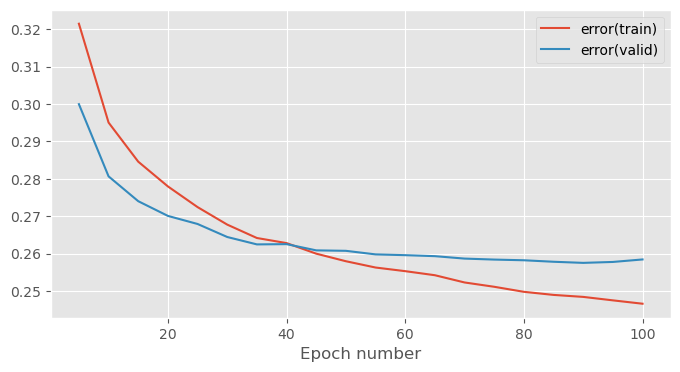

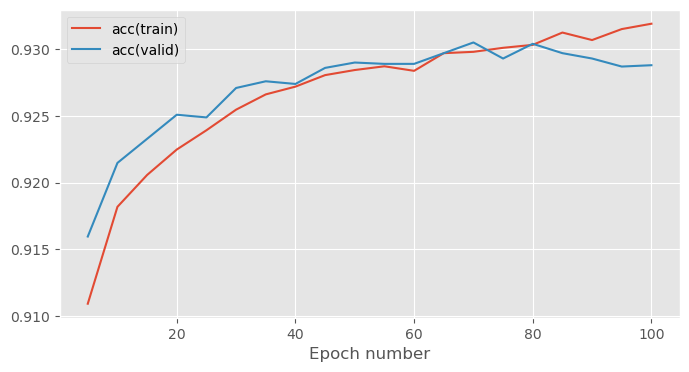

In [3]:
# Set training run hyperparameters
batch_size = 128  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

### Optional extra: more efficient softmax gradient evaluation

In the lectures you were shown that for certain combinations of error function and final output layers, that the expressions for the gradients take particularly simple forms. 

In particular it can be shown that the combinations of 

  * logistic sigmoid output layer and binary cross entropy error function
  * softmax output layer and cross entropy error function
 
lead to particularly simple forms for the gradients of the error function with respect to the inputs to the final layer. In particular for the latter softmax and cross entropy error function case we have that

\begin{eqnarray}
    y^{(b)}_k &=& \textrm{Softmax}_k\left(\boldsymbol{x}^{(b)}\right) = \frac{\exp(x^{(b)}_k)}{\sum_{d=1}^D \left\lbrace \exp(x^{(b)}_d) \right\rbrace}\\
    E^{(b)} &=& \textrm{CrossEntropy}\left(\boldsymbol{y}^{(b)},\,\boldsymbol{t}^{(b)}\right) = -\sum_{d=1}^D \left\lbrace t^{(b)}_d \log(y^{(b)}_d) \right\rbrace
\end{eqnarray}

and it can be shown (this is an instructive mathematical exercise if you want a challenge!) that

\begin{equation}
    \frac{\partial E^{(b)}}{\partial x^{(b)}_d} = y^{(b)}_d - t^{(b)}_d.
\end{equation}

The combination of `CrossEntropyError` and `SoftmaxLayer` used to train the model above calculate this gradient less directly by first calculating the gradient of the error with respect to the model outputs in `CrossEntropyError.grad` and then back-propagating this gradient to the inputs of the softmax layer using `SoftmaxLayer.bprop`.

Rather than computing the gradient in two steps like this we can instead wrap the softmax transformation in to the definition of the error function and make use of the simpler gradient expression above. More explicitly we define an error function as follows

\begin{equation}
    E^{(b)} = \textrm{CrossEntropySoftmax}\left(\boldsymbol{y}^{(b)},\,\boldsymbol{t}^{(b)}\right) = -\sum_{d=1}^D \left\lbrace t^{(b)}_d \log\left[\textrm{Softmax}_d\left( \boldsymbol{y}^{(b)}\right)\right]\right\rbrace
\end{equation}

with corresponding gradient

\begin{equation}
    \frac{\partial E^{(b)}}{\partial y^{(b)}_d} = \textrm{Softmax}_d\left( \boldsymbol{y}^{(b)}\right) - t^{(b)}_d.
\end{equation}

The final layer of the model will then be an affine transformation which produces unbounded output values corresponding to the logarithms of the unnormalised predicted class probabilities. An implementation of this error function is provided in `CrossEntropySoftmaxError`. The cell below sets up a model with a single affine transformation layer and trains it on MNIST using this new cost. If you run it with equivalent hyperparameters to one of your runs with the alternative formulation above you should get identical error and classification curves (other than floating point error) but with a minor improvement in training speed.


Epoch 5: 3.0s to complete
    error(train)=3.22e-01, acc(train)=9.11e-01, error(valid)=3.00e-01, acc(valid)=9.16e-01
Epoch 10: 2.7s to complete
    error(train)=2.95e-01, acc(train)=9.18e-01, error(valid)=2.81e-01, acc(valid)=9.21e-01
Epoch 15: 3.4s to complete
    error(train)=2.85e-01, acc(train)=9.21e-01, error(valid)=2.74e-01, acc(valid)=9.23e-01
Epoch 20: 2.8s to complete
    error(train)=2.78e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.25e-01
Epoch 25: 3.3s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.68e-01, acc(valid)=9.25e-01
Epoch 30: 2.8s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.64e-01, acc(valid)=9.27e-01
Epoch 35: 3.3s to complete
    error(train)=2.64e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.28e-01
Epoch 40: 2.9s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.63e-01, acc(valid)=9.27e-01
Epoch 45: 2.8s to complete
    error(train)=2.60e-01, acc

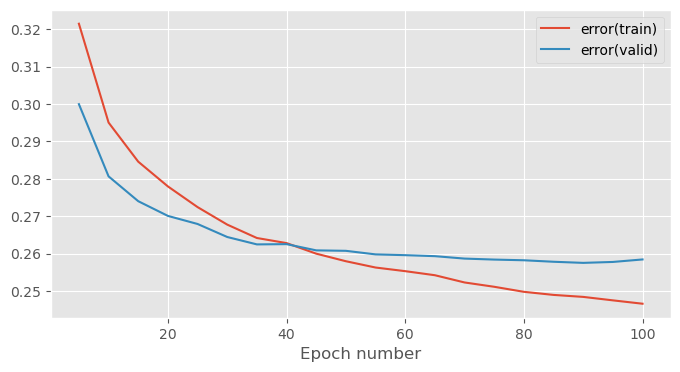

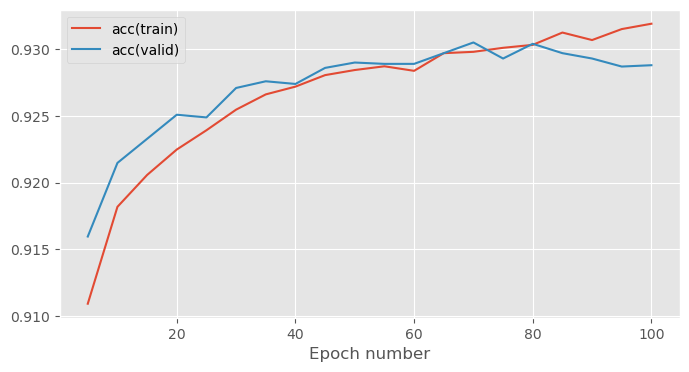

In [4]:
# Set training run hyperparameters
batch_size = 128  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine model (outputs are logs of unnormalised class probabilities)
model = SingleLayerModel(
    AffineLayer(input_dim, output_dim, param_init, param_init)
)

# Initialise the error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

## Exercise 2: training deeper models on MNIST

We are now going to investigate using deeper multiple-layer model archictures for the MNIST classification task. You should experiment with training models with two to five `AffineLayer` transformations interleaved with `SigmoidLayer` nonlinear transformations. Intermediate hidden layers between the input and output should have a dimension of 100. For example the `layers` definition of a model with two `AffineLayer` transformations would be

```python
layers = [
    AffineLayer(input_dim, 100),
    SigmoidLayer(),
    AffineLayer(100, output_dim),
    SoftmaxLayer()
]
```

If you read through the extension to the first exercise you may wish to use the `CrossEntropySoftmaxError` without the final `SoftmaxLayer`.

Use the code from the first exercise as a starting point to train models of varying depths, and compared their results. It is a good idea to start with training hyperparameters which gave reasonable performance for the shallow architecture trained previously.

Some questions to investigate:

  * How does increasing the number of layers affect the model's performance on the training data set? And on the validation data set?
  * Do deeper models seem to be harder or easier to train (e.g. in terms of ease of choosing training hyperparameters to give good final performance and/or quick convergence)?
  * Do the models seem to be sensitive to the choice of the parameter initialisation range? Can you think of any reasons for why setting individual parameter initialisation scales for each `AffineLayer` in a model might be useful? Can you come up with (or find) any heuristics for setting the parameter initialisation scales?
  
You do not need to come up with explanations for all of these (though if you can that's great!), they are meant as prompts to get you thinking about the various issues involved in training multiple-layer models. 

You may wish to start with shorter pilot training runs (by decreasing the number of training epochs) for each of the model architectures to get an initial idea of appropriate hyperparameter settings before doing one or two longer training runs to assess the final performance of the architectures.

### Models with two affine layers

--------------------------------------------------------------------------------
learning_rate=0.20 init_scale=0.10
--------------------------------------------------------------------------------


Epoch 5: 13.6s to complete
    error(train)=2.44e-01, acc(train)=9.30e-01, error(valid)=2.29e-01, acc(valid)=9.34e-01
Epoch 10: 20.4s to complete
    error(train)=1.75e-01, acc(train)=9.50e-01, error(valid)=1.72e-01, acc(valid)=9.53e-01
Epoch 15: 10.6s to complete
    error(train)=1.37e-01, acc(train)=9.61e-01, error(valid)=1.43e-01, acc(valid)=9.59e-01
Epoch 20: 12.5s to complete
    error(train)=1.11e-01, acc(train)=9.69e-01, error(valid)=1.23e-01, acc(valid)=9.66e-01
Epoch 25: 9.6s to complete
    error(train)=9.37e-02, acc(train)=9.75e-01, error(valid)=1.12e-01, acc(valid)=9.70e-01
Epoch 30: 7.8s to complete
    error(train)=7.95e-02, acc(train)=9.79e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01
Epoch 35: 12.1s to complete
    error(train)=6.90e-02, acc(train)=9.82e-01, error(valid)=9.57e-02, acc(valid)=9.73e-01
Epoch 40: 13.3s to complete
    error(train)=6.08e-02, acc(train)=9.84e-01, error(valid)=9.19e-02, acc(valid)=9.74e-01
Epoch 45: 9.3s to complete
    error(train)=5.37e-0

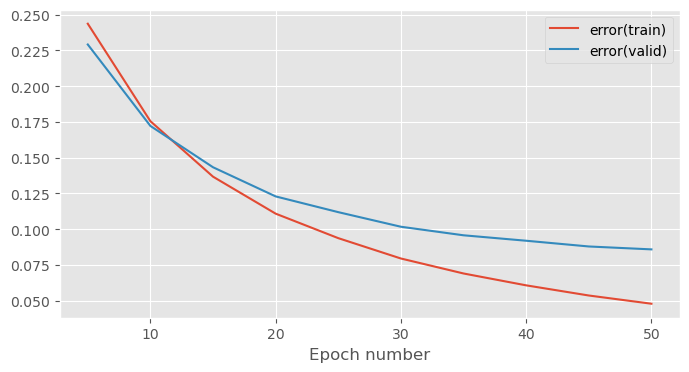

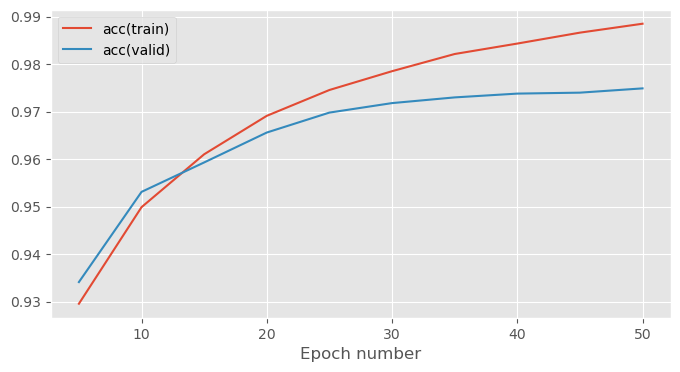

    final error(train) = 4.79e-02
    final error(valid) = 8.59e-02
    final acc(train)   = 9.89e-01
    final acc(valid)   = 9.75e-01
--------------------------------------------------------------------------------
learning_rate=0.20 init_scale=0.20
--------------------------------------------------------------------------------


Epoch 5: 19.8s to complete
    error(train)=2.36e-01, acc(train)=9.32e-01, error(valid)=2.23e-01, acc(valid)=9.35e-01
Epoch 10: 9.1s to complete
    error(train)=1.70e-01, acc(train)=9.52e-01, error(valid)=1.69e-01, acc(valid)=9.55e-01
Epoch 15: 10.4s to complete
    error(train)=1.33e-01, acc(train)=9.62e-01, error(valid)=1.41e-01, acc(valid)=9.59e-01
Epoch 20: 6.6s to complete
    error(train)=1.08e-01, acc(train)=9.70e-01, error(valid)=1.22e-01, acc(valid)=9.67e-01
Epoch 25: 10.2s to complete
    error(train)=9.19e-02, acc(train)=9.75e-01, error(valid)=1.12e-01, acc(valid)=9.69e-01
Epoch 30: 9.1s to complete
    error(train)=7.81e-02, acc(train)=9.79e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01
Epoch 35: 8.2s to complete
    error(train)=6.79e-02, acc(train)=9.83e-01, error(valid)=9.58e-02, acc(valid)=9.72e-01
Epoch 40: 8.5s to complete
    error(train)=5.98e-02, acc(train)=9.85e-01, error(valid)=9.15e-02, acc(valid)=9.74e-01
Epoch 45: 9.3s to complete
    error(train)=5.30e-02, 

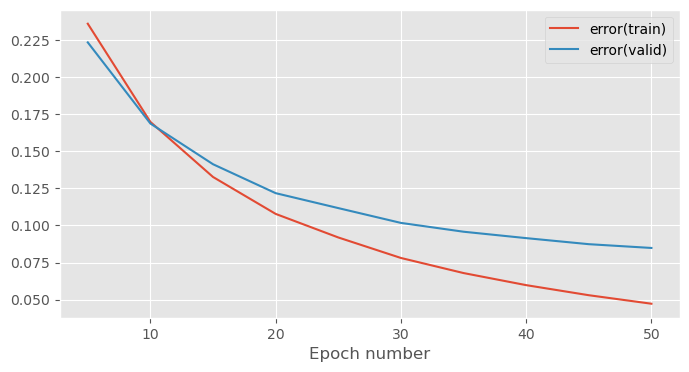

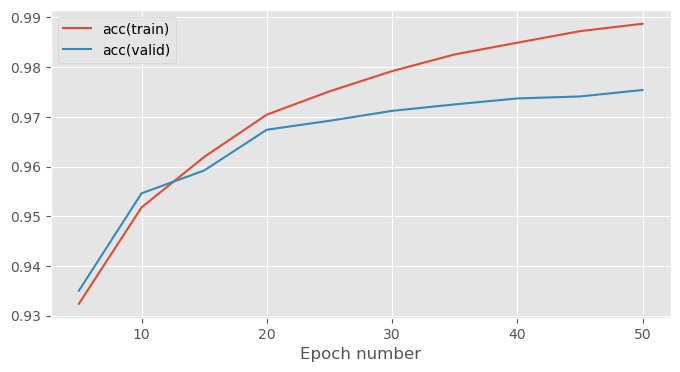

    final error(train) = 4.72e-02
    final error(valid) = 8.48e-02
    final acc(train)   = 9.89e-01
    final acc(valid)   = 9.75e-01
--------------------------------------------------------------------------------
learning_rate=0.20 init_scale=0.50
--------------------------------------------------------------------------------


Epoch 5: 5.5s to complete
    error(train)=2.32e-01, acc(train)=9.34e-01, error(valid)=2.20e-01, acc(valid)=9.36e-01
Epoch 10: 11.4s to complete
    error(train)=1.69e-01, acc(train)=9.51e-01, error(valid)=1.71e-01, acc(valid)=9.52e-01
Epoch 15: 10.5s to complete
    error(train)=1.34e-01, acc(train)=9.62e-01, error(valid)=1.48e-01, acc(valid)=9.58e-01
Epoch 20: 15.1s to complete
    error(train)=1.10e-01, acc(train)=9.69e-01, error(valid)=1.31e-01, acc(valid)=9.64e-01
Epoch 25: 8.9s to complete
    error(train)=9.51e-02, acc(train)=9.74e-01, error(valid)=1.22e-01, acc(valid)=9.66e-01
Epoch 30: 9.4s to complete
    error(train)=8.12e-02, acc(train)=9.78e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01
Epoch 35: 40.1s to complete
    error(train)=7.13e-02, acc(train)=9.81e-01, error(valid)=1.08e-01, acc(valid)=9.69e-01
Epoch 40: 19.2s to complete
    error(train)=6.37e-02, acc(train)=9.84e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01
Epoch 45: 12.1s to complete
    error(train)=5.58e-0

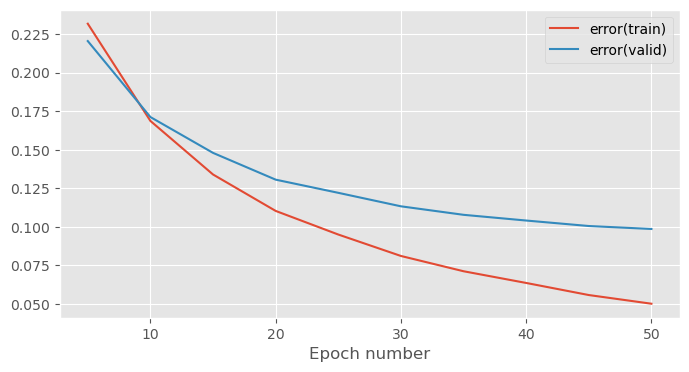

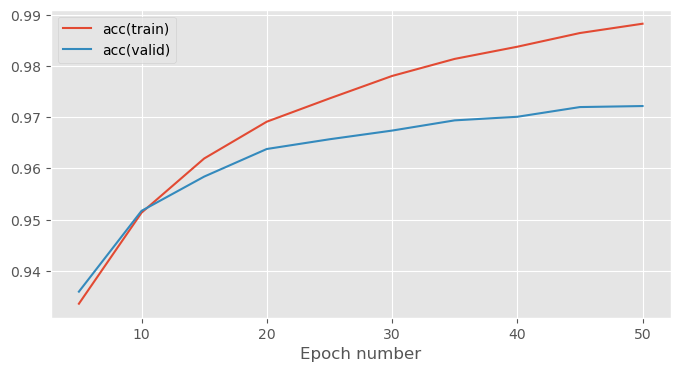

    final error(train) = 5.02e-02
    final error(valid) = 9.87e-02
    final acc(train)   = 9.88e-01
    final acc(valid)   = 9.72e-01
--------------------------------------------------------------------------------
learning_rate=0.20 init_scale=1.00
--------------------------------------------------------------------------------


Epoch 5: 9.8s to complete
    error(train)=2.73e-01, acc(train)=9.19e-01, error(valid)=2.57e-01, acc(valid)=9.24e-01
Epoch 10: 7.0s to complete
    error(train)=2.05e-01, acc(train)=9.40e-01, error(valid)=2.07e-01, acc(valid)=9.39e-01
Epoch 15: 8.0s to complete
    error(train)=1.68e-01, acc(train)=9.50e-01, error(valid)=1.85e-01, acc(valid)=9.46e-01
Epoch 20: 10.8s to complete
    error(train)=1.43e-01, acc(train)=9.58e-01, error(valid)=1.67e-01, acc(valid)=9.50e-01
Epoch 25: 9.1s to complete
    error(train)=1.26e-01, acc(train)=9.63e-01, error(valid)=1.58e-01, acc(valid)=9.53e-01
Epoch 30: 11.7s to complete
    error(train)=1.11e-01, acc(train)=9.68e-01, error(valid)=1.49e-01, acc(valid)=9.55e-01
Epoch 35: 7.9s to complete
    error(train)=9.94e-02, acc(train)=9.72e-01, error(valid)=1.43e-01, acc(valid)=9.58e-01
Epoch 40: 8.1s to complete
    error(train)=9.06e-02, acc(train)=9.75e-01, error(valid)=1.40e-01, acc(valid)=9.59e-01
Epoch 45: 8.5s to complete
    error(train)=8.13e-02, a

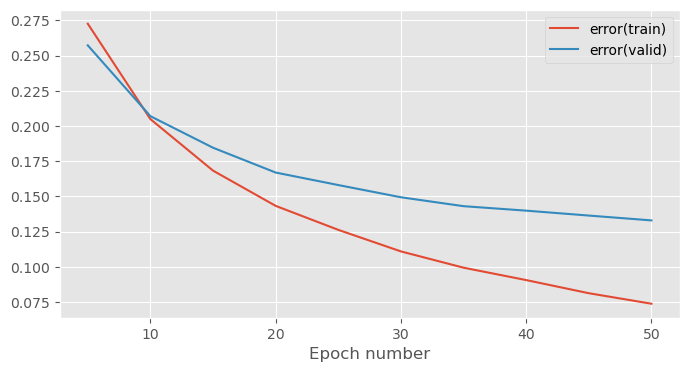

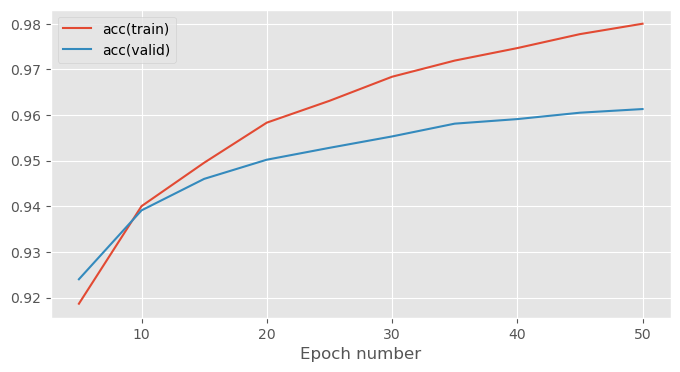

    final error(train) = 7.38e-02
    final error(valid) = 1.33e-01
    final acc(train)   = 9.80e-01
    final acc(valid)   = 9.61e-01


In [9]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
num_epochs = 50  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate = 0.2  # learning rate for gradient descent

init_scales = [0.1, 0.2, 0.5, 1.]  # scale for random parameter initialisation
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for init_scale in init_scales:

    print('-' * 80)
    print('learning_rate={0:.2f} init_scale={1:.2f}'
          .format(learning_rate, init_scale))
    print('-' * 80)
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    # Alter data-provider batch size
    train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size

    # Create a parameter initialiser which will sample random uniform values
    # from [-init_scale, init_scale]
    param_init = UniformInit(-init_scale, init_scale, rng=rng)

    # Create a model with two affine layers
    hidden_dim = 100
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, param_init, param_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
  #  print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

### Models with three affine layers

--------------------------------------------------------------------------------
learning_rate=0.20 init_scale=0.10
--------------------------------------------------------------------------------


Epoch 5: 9.1s to complete
    error(train)=2.93e-01, acc(train)=9.15e-01, error(valid)=2.76e-01, acc(valid)=9.21e-01
Epoch 10: 8.4s to complete
    error(train)=1.86e-01, acc(train)=9.46e-01, error(valid)=1.83e-01, acc(valid)=9.48e-01
Epoch 15: 16.5s to complete
    error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.37e-01, acc(valid)=9.62e-01
Epoch 20: 23.2s to complete
    error(train)=1.02e-01, acc(train)=9.71e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01
Epoch 25: 10.5s to complete
    error(train)=7.89e-02, acc(train)=9.78e-01, error(valid)=1.05e-01, acc(valid)=9.70e-01
Epoch 30: 11.9s to complete
    error(train)=6.55e-02, acc(train)=9.82e-01, error(valid)=9.80e-02, acc(valid)=9.72e-01
Epoch 35: 10.6s to complete
    error(train)=5.31e-02, acc(train)=9.86e-01, error(valid)=9.40e-02, acc(valid)=9.74e-01
Epoch 40: 16.5s to complete
    error(train)=4.22e-02, acc(train)=9.90e-01, error(valid)=8.83e-02, acc(valid)=9.75e-01
Epoch 45: 14.2s to complete
    error(train)=3.44e-

ValueError: not enough values to unpack (expected 7, got 6)

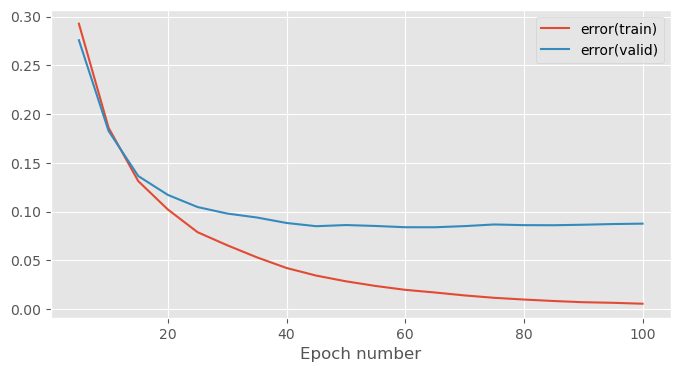

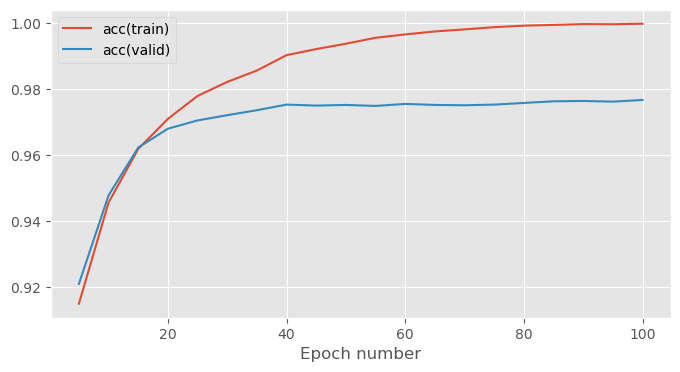

In [6]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate = 0.2  # learning rate for gradient descent

init_scales = [0.1, 0.2, 0.5, 1.]  # scale for random parameter initialisation
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for init_scale in init_scales:

    print('-' * 80)
    print('learning_rate={0:.2f} init_scale={1:.2f}'
          .format(learning_rate, init_scale))
    print('-' * 80)
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    # Alter data-provider batch size
    train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size

    # Create a parameter initialiser which will sample random uniform values
    # from [-init_scale, init_scale]
    param_init = UniformInit(-init_scale, init_scale, rng=rng)

    # Create a model with three affine layers
    hidden_dim = 100
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, param_init, param_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys,  fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
  #  print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))
    
    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

### Models with four affine layers

### Models with five affine layers

## Exercise 3: Hyperbolic tangent and rectified linear layers

In the models we have been investigating so far, we have been applying elementwise logistic sigmoid transformations to the outputs of intermediate (affine) layers. The logistic sigmoid is just one particular choice of an elementwise non-linearity we can use. 

As discussed in [lecture 3](https://www.learn.ed.ac.uk/bbcswebdav/pid-5970416-dt-content-rid-16249607_1/xid-16249607_1), although logistic sigmoid has some favourable properties in terms of interpretability, there are also disadvantages from a computational perspective. In particular:
1. the gradients of the sigmoid become close to zero (and may actually become zero because of finite numerical precision) for large positive or negative inputs, 
2. the outputs are non-centred - they cover the interval $[0,\,1]$ so negative outputs are never produced.

Two alternative elementwise non-linearities which are often used in multiple layer models are the hyperbolic tangent (tanh)  and the rectified linear function (ReLU).

For tanh (`TanhLayer`) layer the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \tanh\left(x^{(b)}_k\right) = 
    \frac{\exp\left(x^{(b)}_k\right) - \exp\left(-x^{(b)}_k\right)}{\exp\left(x^{(b)}_k\right) + \exp\left(-x^{(b)}_k\right)}
\end{equation}

which has corresponding partial derivatives

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 - \left(y^{(b)}_k\right)^2 & \quad k = d \\
      0 & \quad k \neq d
    \end{cases}.
\end{equation}

For a ReLU (`ReluLayer`) the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \max\left(0,\,x^{(b)}_k\right)
\end{equation}

which has corresponding partial derivatives

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 & \quad k = d \quad\textrm{and} &x^{(b)}_d > 0 \\
      0 & \quad k \neq d \quad\textrm{or} &x^{(b)}_d < 0
    \end{cases}.
\end{equation}

Using these definitions implement the `fprop` and `bprop` methods for the skeleton `TanhLayer` and `ReluLayer` class definitions below.

In [11]:
import numpy as np
from mlp.layers import Layer

class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

Test your implementations by running the cells below.

In [12]:
test_inputs = np.array([[0.1, -0.2, 0.3], [-0.4, 0.5, -0.6]])
test_grads_wrt_outputs = np.array([[5., 10., -10.], [-5., 0., 10.]])
test_tanh_outputs = np.array(
    [[ 0.09966799, -0.19737532,  0.29131261],
     [-0.37994896,  0.46211716, -0.53704957]])
test_tanh_grads_wrt_inputs = np.array(
    [[ 4.95033145,  9.61042983, -9.15136962],
     [-4.27819393,  0.,          7.11577763]])
tanh_layer = TanhLayer()
tanh_outputs = tanh_layer.fprop(test_inputs)
all_correct = True
if not tanh_outputs.shape == test_tanh_outputs.shape:
    print('TanhLayer.fprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(test_tanh_outputs, tanh_outputs):
    print('TanhLayer.fprop calculated incorrect outputs.')
    all_correct = False
tanh_grads_wrt_inputs = tanh_layer.bprop(
    test_inputs, tanh_outputs, test_grads_wrt_outputs)
if not tanh_grads_wrt_inputs.shape == test_tanh_grads_wrt_inputs.shape:
    print('TanhLayer.bprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(tanh_grads_wrt_inputs, test_tanh_grads_wrt_inputs):
    print('TanhLayer.bprop calculated incorrect gradients with respect to inputs.')
    all_correct = False
if all_correct:
    print('Outputs and gradients calculated correctly for TanhLayer.')

Outputs and gradients calculated correctly for TanhLayer.


In [13]:
test_inputs = np.array([[0.1, -0.2, 0.3], [-0.4, 0.5, -0.6]])
test_grads_wrt_outputs = np.array([[5., 10., -10.], [-5., 0., 10.]])
test_relu_outputs = np.array([[0.1, 0., 0.3], [0., 0.5, 0.]])
test_relu_grads_wrt_inputs = np.array([[5., 0., -10.], [-0., 0., 0.]])
relu_layer = ReluLayer()
relu_outputs = relu_layer.fprop(test_inputs)
all_correct = True
if not relu_outputs.shape == test_relu_outputs.shape:
    print('ReluLayer.fprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(test_relu_outputs, relu_outputs):
    print('ReluLayer.fprop calculated incorrect outputs.')
    all_correct = False
relu_grads_wrt_inputs = relu_layer.bprop(
    test_inputs, relu_outputs, test_grads_wrt_outputs)
if not relu_grads_wrt_inputs.shape == test_relu_grads_wrt_inputs.shape:
    print('ReluLayer.bprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(relu_grads_wrt_inputs, test_relu_grads_wrt_inputs):
    print('ReluLayer.bprop calculated incorrect gradients with respect to inputs.')
    all_correct = False
if all_correct:
    print('Outputs and gradients calculated correctly for ReluLayer.')

Outputs and gradients calculated correctly for ReluLayer.


# PyTorch

In this section we will builld on we learned in the previous lab and will use PyTorch to build a multi-layer model for the MNIST classification task. 

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

torch.manual_seed(seed)

Neural networks are typically take a long time to converge. This process can be sped up by using a GPU. If you have a GPU available, you can use it by setting the `device` variable below to `cuda`. If you do not have a GPU available, you can still run the code on the CPU by setting `device` to `cpu`.

When training, both the model and the data should be on the same device. The `to` method can be used to move a tensor to a device. For example, `x = x.to(device)` will move the tensor `x` to the device specified by `device`. Look through the code to see where we put the model and the data on the CPU or GPU device.

In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
# Set training run hyperparameters
batch_size = 128  # number of data points in a batch
learning_rate = 0.001  # learning rate for gradient descent
num_epochs = 50  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

The [transforms](https://pytorch.org/vision/0.9/transforms.html) are common transformations for the image datasets. We will use the `Compose` transform to combine the `ToTensor` and `Normalize` transforms. The `ToTensor` transform converts the image to a tensor and the `Normalize` transform normalizes the image by subtracting the mean and dividing by the standard deviation. The `Normalize` transform takes two arguments: the mean and the standard deviation. The mean and standard deviation are calculated for each channel. The mean and standard deviation for the MNIST dataset are $0.1307$ and $0.3081$ respectively. `Normalize` transform is particularly useful when there is a big discrepancy between the values of the pixels in an image.

When working with images, transforms are used to augment the dataset (i.e. create artificial images based on existing ones). This is done to increase the size of the dataset and to make the model more robust to changes in the input images. An illustration of how transforms affect an image is shown [here](https://pytorch.org/vision/0.11/auto_examples/plot_transforms.html#sphx-glr-download-auto-examples-plot-transforms-py).

In [19]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

Popular machine learning datasets are available in the [`torchvision.datasets`](https://pytorch.org/vision/0.15/datasets.html) module. The `MNIST` dataset is available in the [`torchvision.datasets.MNIST`](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) class. This way, we can download the dataset directly from the PyTorch library into the `data` folder of our repository. 

The `MNIST` class takes the following arguments:
- `root`: the path where the dataset will be stored
- `train`: if `True`, the training set is returned, otherwise the test set is returned
- `download`: if `True`, the dataset is downloaded from the internet and put in `root`. If the dataset is already downloaded, it is not downloaded again
- `transform`: the transform to be applied to the dataset

In [20]:
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [21]:
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

We can see that the training set has $60,000$ images and the test set has $10,000$ images. Each image is a $28 \times 28$ grayscale image. 

In [31]:
print("Train dataset: \n", train_dataset)
print(train_dataset.data.size())
print(train_dataset.targets.size())
print("\nTest dataset: \n", test_dataset)


Train dataset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
torch.Size([60000, 28, 28])
torch.Size([60000])

Test dataset: 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


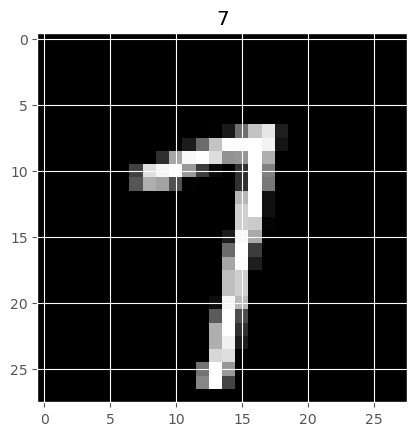

In [32]:
plt.imshow(train_dataset.data[42], cmap='gray')
plt.title('%i' % train_dataset.targets[42])
plt.show()

However, since we want to evaluate the performance of our model during training, we need a validation set. We can create a validation set by splitting the training set into two parts. As a general rule, the validation set should be $10-20\%$ of the training set. The `SubsetRandomSampler` class can be used to create a subset of the training set. The `SubsetRandomSampler` class takes a list of randomly shuffled indices as an argument and selects a subset of the training set based on these indices.

*Why would we want to randomly shuffle the data when creating the separate training and validation set?*

*We could just take the first 80% of data points and assign them to the training set and the last 20% of data points to the validation set. When and why would this be a bad practice?*

*Why do we want to shuffle the training and valisation sets but not the test set (see `shuffle=False`)?*

In [33]:
valid_size=0.2 # Leave 20% of training set as validation set
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices) # Shuffle indices in-place
train_idx, valid_idx = indices[split:], indices[:split] # Split indices into training and validation sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

To create a multy-layer model, we will use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) container. The `nn.Sequential` container takes a list of layers as an argument and applies them sequentially. The `nn.Sequential` container is a convenient way to create a model with multiple layers. However, it is not very flexible. For example, we cannot have skip connections in a model created using the `nn.Sequential` container.

Since we are working with images, we will have to flatten the images before passing them to the model. We can do this using the [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) layer. The `nn.Flatten` layer takes a tensor of shape `(N, C, H, W)` and flattens it to a tensor of shape `(N, C*H*W)`.

In between the affine layers, we will use the [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation function. The `nn.ReLU` activation function applies the ReLU function elementwise to the input tensor. There are other acrtivation functions available in PyTorch, such as the [`nn.Tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) activation function, the [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function, and the [`nn.LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activation function. The `nn.LeakyReLU` activation function is similar to the `nn.ReLU` activation function, but it allows a small gradient when the input is negative. This can help with training.

In [34]:
class MultipleLayerModel(nn.Module):
    """Multiple layer model."""
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Since our image size is $1 \times 28 \times 28$, this will be the output size of the `nn.Flatten` layer. The input size of the first affine layer that will take in $x_i$ datapoints will be $1 \times 28 \times 28$ and the output size will be $100$. The input size of the second affine layer will be $100$ and the output size will be $10$. The output size of the second affine layer is 10 because we have $10$ classes in the MNIST dataset. Therefore, the last layer will out put the a vector $y = (y_1, \dots, y_{K})^{\top}$ where $y_k$ is the probability that the image belongs to class $k$.

In [35]:
input_dim = 1*28*28
output_dim = 10
hidden_dim = 100

model = MultipleLayerModel(input_dim, output_dim, hidden_dim).to(device)
print(model)

MultipleLayerModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


As we want to calissify images by their labels, we will use the [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss function. The `nn.CrossEntropyLoss` loss function combines the softmax function and the cross entropy loss function. The `nn.CrossEntropyLoss` loss function takes the logits as an input and returns the loss. The logits are the outputs of the last affine layer before the softmax function is applied. The `nn.CrossEntropyLoss` loss function is equivalent to applying the softmax function to the logits and then applying the cross entropy loss function to the softmax outputs and the labels.

In [36]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimiser

Now, our training loop will combine a training and an evaluation pass per epoch. During the training pass, we propagate the training data through the model and calculate the loss. Then, we calculate the gradients of the loss with respect to the parameters of the model and update the parameters of the model. During the evaluation pass, we propagate the validation data through the model and calculate the loss and the accuracy. We do not calculate the gradients of the loss with respect to the parameters of the model and we do not update the parameters of the model. 

*What would happen if we do?*

In [ ]:
# Keep track of the loss values over training
train_loss = [] 
valid_loss = []

# Keep track of the accuracy values over training
train_acc = []
valid_acc = []

for i in range(num_epochs+1):
    # Training
    model.train()
    batch_loss = []
    batch_acc = []
    for batch_idx, (x, t) in enumerate(train_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Backward pass
        optimizer.zero_grad()
        E_value.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, argmax = torch.max(y, 1)
        acc = (t == argmax.squeeze()).float().mean()
        
        # Logging
        batch_loss.append(E_value.item())
        batch_acc.append(acc.item())
    
    train_loss.append(np.mean(batch_loss))
    train_acc.append(np.mean(batch_acc))

    # Validation
    model.eval()
    batch_loss = []
    batch_acc = []
    for batch_idx, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Calculate accuracy
        _, argmax = torch.max(y, 1)
        acc = (t == argmax.squeeze()).float().mean()
        
        # Logging
        batch_loss.append(E_value.item())
        batch_acc.append(acc.item())
    
    valid_loss.append(np.mean(batch_loss))
    valid_acc.append(np.mean(batch_acc))

    if i % stats_interval == 0:
        print('Epoch: {} \tError(train): {:.6f} \tAccuracy(train): {:.6f} \tError(valid): {:.6f} \tAccuracy(valid): {:.6f}'.format(
            i, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))

Epoch: 0 	Error(train): 0.361186 	Accuracy(train): 0.897208 	Error(valid): 0.175166 	Accuracy(valid): 0.947529
Epoch: 5 	Error(train): 0.051526 	Accuracy(train): 0.984146 	Error(valid): 0.097927 	Accuracy(valid): 0.971022
Epoch: 10 	Error(train): 0.021214 	Accuracy(train): 0.992771 	Error(valid): 0.087528 	Accuracy(valid): 0.977671


In [ ]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(train_loss, label='Error(train)')
ax_1.plot(valid_loss, label='Error(valid)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
ax_2.plot(train_acc, label='Accuracy(train)')
ax_2.plot(valid_acc, label='Accuracy(valid)')
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
plt.show()

Once our model is training and we are satisfied with the results, we can test its performance on unseen data. We can do this by propagating the test data through the model and calculating the accuracy. We can see that the test accuracy is similar to the validation accuracy.

*Altought using a test set is not necessary for training, why is it important to have a one?*

In [ ]:
# Testing
test_acc = []
model.eval()
for batch_idx, (x, t) in enumerate(test_loader):
    x = x.to(device)
    t = t.to(device)

    # Forward pass
    y = model(x)
    
    # Calculate accuracy
    _, argmax = torch.max(y, 1)
    acc = (t == argmax.squeeze()).float().mean()
    
    test_acc.append(acc.item())
test_acc = np.mean(test_acc)
print('Accuracy(test): {:.6f}'.format(test_acc))